# Naive Bayes classifier

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [13]:
class NaiveBayesClassifier:
    def __init__(self, train_data: np.ndarray, train_labels: np.ndarray, test_data: np.ndarray, test_labels: np.ndarray):
        self.train_data = train_data
        self.train_labels = train_labels
        self.test_data = test_data
        self.test_labels = test_labels

    def train(self):
        self.prior = self.calculate_prior()
        self.mean, self.var = self.calculate_likelihood()

    def calculate_prior(self) -> dict:
        """Calculate the prior probabilities of each class."""
        prior = {}
        for label in np.unique(self.train_labels):
            prior[label] = np.sum(self.train_labels == label) / len(self.train_labels)
        return prior

    def calculate_likelihood(self) -> tuple:
        """Calculate the mean and variance for each feature per class."""
        mean = {}
        var = {}
        for label in np.unique(self.train_labels):
            data = self.train_data[self.train_labels == label]
            mean[label] = data.mean(axis=0)
            var[label] = data.var(axis=0) + 1e-9  # Add small constant to avoid division by zero
        return mean, var

    def predict(self, data: np.ndarray) -> np.ndarray:
        """Predict the class for each sample in the dataset."""
        return np.array([self.predict_single(sample) for sample in data])

    def predict_single(self, data: np.ndarray) -> int:
        """Predict the class for a single data point."""
        log_probabilities = {}
        for label in self.prior:
            # Start with the log prior
            log_probabilities[label] = np.log(self.prior[label])
            # Add log likelihood for each feature
            log_probabilities[label] += np.sum(
                self.log_gaussian_probability(feature_idx, data[feature_idx], label)
                for feature_idx in range(data.shape[0])
            )
        return max(log_probabilities, key=log_probabilities.get)

    def log_gaussian_probability(self, feature_index: int, x: float, label: int) -> float:
        """Compute the log of the Gaussian probability density function for a given feature."""
        mean = self.mean[label][feature_index]
        var = self.var[label][feature_index]
        return -0.5 * np.log(2 * np.pi * var) - ((x - mean) ** 2) / (2 * var)

    def accuracy(self) -> float:
        """Calculate the accuracy of the model on the test data."""
        predictions = self.predict(self.test_data)
        return np.mean(predictions == self.test_labels)

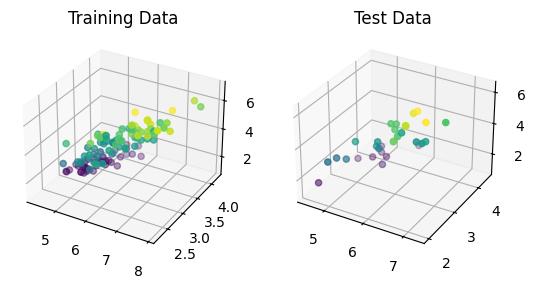

In [14]:
data = load_iris()

training_data, test_data, training_labels, test_labels = train_test_split(data.data, data.target, test_size=0.2)


training_data = np.column_stack((training_data, training_labels))
test_data = np.column_stack((test_data, test_labels))

fig = plt.figure()
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(training_data[:, 0], training_data[:, 1], training_data[:, 2], c=training_data[:, 3])
ax1.title.set_text('Training Data')
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(test_data[:, 0], test_data[:, 1], test_data[:, 2], c=test_data[:, 3])
ax2.title.set_text('Test Data')
plt.show()

In [15]:
model = NaiveBayesClassifier(training_data[:, :-1], training_data[:, -1], test_data[:, :-1], test_data[:, -1])
model.train()
predictions = model.predict(test_data[:, :-1])
print(predictions)
print(test_data[:, -1])

print(f"Accuracy: {model.accuracy() * 100:.2f}%")

[0. 2. 2. 0. 0. 2. 2. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 2. 0. 2. 2. 0. 2. 1.
 2. 1. 0. 2. 0. 2.]
[0. 2. 1. 0. 0. 2. 2. 2. 1. 1. 1. 0. 1. 1. 1. 1. 1. 2. 0. 2. 2. 0. 2. 1.
 2. 1. 0. 2. 0. 2.]
Accuracy: 93.33%


/var/folders/mm/lb5z5dxd38s4fkfnmb7yhcyr0000gn/T/ipykernel_44228/4223454251.py:40: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  log_probabilities[label] += np.sum(


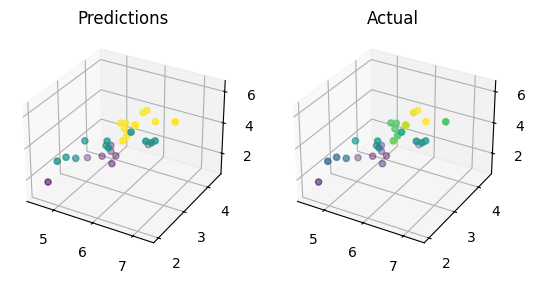

In [16]:
fig = plt.figure()
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(test_data[:, 0], test_data[:, 1], test_data[:, 2], c=predictions)
ax1.title.set_text('Predictions')
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(test_data[:, 0], test_data[:, 1], test_data[:, 2], c=test_data[:, 3])
ax2.title.set_text('Actual')
plt.show()